In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
import findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"
findspark.init()

spark-3.0.0-preview2-bin-hadoop2.7/
spark-3.0.0-preview2-bin-hadoop2.7/data/
spark-3.0.0-preview2-bin-hadoop2.7/data/streaming/
spark-3.0.0-preview2-bin-hadoop2.7/data/streaming/AFINN-111.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_binary_classification_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_kmeans_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_multiclass_classification_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_lda_libsvm_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/iris_libsvm.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/pagerank_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_linear_regression_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/pic_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/test.data
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/sample_movielens_rati

In [4]:
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

/content/spark-3.0.0-preview2-bin-hadoop2.7/python/pyspark/context.py:219: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [0]:
import pyspark
from pyspark.sql import SQLContext

conf = pyspark.SparkConf()
# conf.set('spark.app.name', app_name) # Optional configurations

# init & return
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlc = SQLContext(sc)

In [0]:
!rm -rf ./metastore_db/
#pyspark --executor-memory 8g --driver-memory 8g --conf spark.driver.maxResultSize=2g

#Import Libraries

In [0]:
import os
import findspark
import pyspark
import numpy as np
import json
import pickle
import shutil
import seaborn as sns
from time import mktime
from datetime import datetime
from pyspark.ml.feature import StringIndexer, StandardScaler, IndexToString
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction, stddev
from pyspark.sql.functions import * # array, desc, asc, mean
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType, IntegerType
%matplotlib inline

In [0]:
class YelpRecommender(object):
    def __init__(self, folder='./', business_filename=None, reviews_filename=None):
        self._folder = folder
        if business_filename is None:
            business_filename = os.path.join(folder, 'business.json')
        if reviews_filename is None:
            reviews_filename = os.path.join(folder, 'review.json')
        
        self._city = None
        self._category = None
        self._min_per_user = 0
        self._scaler = {'mean': True, 'stdev': False}
        
        self._verbose = True
        self._business = None
        self._reviews = None
        self._city_business = None
        self._city_reviews = None
        self._dataset = None
        self._training = None
        self._test = None
        self._best_model = None
        self._best_parms = None
        self._eval = None
        
        self._business_dict = {}
        self._user_dict = {}
        self._review_dict = {}
        
        self.load_business(business_filename)
        self.load_reviews(reviews_filename)
    
    def console(self, message):
        if self._verbose:
            print(message)
            
    @property
    def best_model(self):
        return self._best_model
    
    @property
    def best_parms(self):
        return self._best_parms
    
    @property
    def evaluation(self):
        return self._eval
    
    @property
    def all_users(self):
        return self._user_dict.keys()
    
    @staticmethod
    def remaining_to_json(row):
        return {row.business_idn: {'name': row.name,
                                   'address': row.address, 
                                   'stars': row.stars, 
                                   'categories': row.categories}}
    
    def load_business(self, filename):
        self.console('Business Data is being Loadef')
        if os.path.exists('./metastore_db/dbex.lck'):
            os.remove('./metastore_db/dbex.lck')    
        business = sqlc.read.json(filename)
        business = business.select('business_id', 'name', 'city', 'stars', 'categories', 'address')
        self._business = business

    def load_reviews(self, filename):
        self.console('Reviews Data is being loaded')
        if os.path.exists('./metastore_db/dbex.lck'):
            os.remove('./metastore_db/dbex.lck')    
        reviews = sqlc.read.json(filename)
        reviews = reviews.select('user_id', 'business_id', 'stars', 'date')
        self._reviews = reviews

    def _get_city_businesses(self, category):
        def is_category_listed(name, categories):
            listed = 0.0
            if categories is not None:
                if name in categories:
                    listed = 1.0
            return listed
        
        is_category = UserDefinedFunction(lambda c: is_category_listed(category, c), DoubleType())

        business_category = self._business.withColumn('is_category', is_category('categories')) \
                                    .filter('is_category = 1.0') \
                                    .drop('is_category')

        city_business = business_category.filter('city = "' + self._city +'"')

        business_indexer = StringIndexer().setInputCol('business_id').setOutputCol('business_idn')
        business_idx_model = business_indexer.fit(city_business)
        city_business = business_idx_model.transform(city_business)

        city_business.cache()

        remaining = city_business.select('business_idn', 'name', 'address', 'stars', 'categories').rdd.collect()
        remaining = map(self.remaining_to_json, remaining)
        remaining = {k: v for d in remaining for k, v in d.items()}

        filename = os.path.join(folder, '%s_%s_business.pickle' % (self._city.replace(' ', '_'), self._category))
        self.console('Sving the Business Date %s ...' % filename)
        with open(filename, 'wb') as f:
            pickle.dump(remaining, f)
        self._business_dict = remaining

        self._city_business = city_business

    def _get_city_reviews(self):
        reviews_city = self._reviews.join(self._city_business.select('business_id', 'business_idn'), on='business_id')

        np.random.seed(42)
        to_timestamp = UserDefinedFunction(lambda d: mktime(datetime.strptime(d, '%Y-%m-%d').timetuple()) + np.random.random(), DoubleType())
        df_selected = reviews_city.select('user_id', 'business_idn', 'stars', to_timestamp('date').alias('timestamp')).drop('date')

        if self._min_per_user > 0:
            df_selected.createOrReplaceTempView('ratings')
            df_selected = sqlc.sql('select user_id, business_idn, stars, timestamp \
                                    from ratings \
                                    where user_id in (select user_id \
                                                      from ratings \
                                                      group by user_id \
                                                      having count(1) > ' + str(self._min_per_user) + ')')

        df_selected.cache()
        user_indexer = StringIndexer().setInputCol('user_id').setOutputCol('user_idn')
        user_idx_model = user_indexer.fit(df_selected)
        df_selected = user_idx_model.transform(df_selected)    

        df_selected.cache()
        user_last = df_selected.select('user_id', 'timestamp').groupby('user_id').max().rdd.collectAsMap()
        user_last_lookup = sc.broadcast(user_last)    

        get_last = UserDefinedFunction(lambda c: user_last_lookup.value.get(c), DoubleType())
        df_selected = df_selected.withColumn('last_time', get_last('user_id'))
        df_selected.cache()

        user_mapping = df_selected.select('user_id', 'user_idn').groupby('user_id').max().rdd.collectAsMap()
        filename = os.path.join(folder, '%s_%s_user.pickle' % (self._city.replace(' ', '_'), self._category))
        self.console('Saving the User Data %s ...' % filename)
        with open(filename, 'wb') as f:
            pickle.dump(user_mapping, f)
        self._user_dict = user_mapping

        all_visited = df_selected.select('user_idn', 'business_idn').groupby('user_idn').agg(collect_list('business_idn')).rdd.collectAsMap()
        filename = os.path.join(folder, '%s_%s_review.pickle' % (self._city.replace(' ', '_'), self._category))
        self.console('Saving the Review Data %s ...' % filename)
        with open(filename, 'wb') as f:
            pickle.dump(all_visited, f)
        self._review_dict = all_visited

        self._city_reviews = df_selected

    def _apply_scaler(self, mean=True, stdev=False):
        if mean:
            user_means = self._city_reviews.select('user_id', 'stars').groupby('user_id').mean().rdd.collectAsMap()
        else:
            user_means = {}

        user_means_lookup = sc.broadcast(user_means)

        if stdev:
            user_stds = self._city_reviews.select('user_id', 'stars').groupby('user_id').agg(stddev('stars').alias('stddev')).rdd.collect()
            user_stds = dict(map(lambda row: (row.user_id, row.stddev if row.stddev > 0.0 else 1.0), user_stds))
        else:
            user_stds = {}
        user_stds_lookup = sc.broadcast(user_stds)    

        center_user_stars = UserDefinedFunction(lambda cols: (float(cols[1]) - user_means_lookup.value.get(cols[0], 0.0))/user_stds_lookup.value.get(cols[0], 1.0), DoubleType())

        df_scaled = self._city_reviews.withColumn('centered', center_user_stars(array('user_id','stars'))) \
                        .drop('stars') \
                        .withColumnRenamed('centered', 'stars')

        df_scaled.cache()

        self._dataset = df_scaled

    def _training_test_split(self):
        training = self._dataset.filter('last_time <> timestamp')
        test = self._dataset.filter('last_time = timestamp')
        
        # https://github.com/apache/spark/pull/12896
        available_business = sc.broadcast(set(training.select('business_idn').distinct().rdd.map(lambda t: t.business_idn).collect()))
        is_available = UserDefinedFunction(lambda idn: 1.0 if idn in available_business.value else 0.0, DoubleType())    
        test = test.withColumn('available', is_available('business_idn'))
        test = test.filter('available = 1.0')

        self._training, self._test = training, test

    def _grid_search(self, paramGrid):
        model_list = []
        eval_lists = {'train_rmse': [], 'test_rmse': []}

        param_list = [dict(map(lambda t: (t[0].name, t[1]), params.items())) for params in paramGrid]

        for idx, params in enumerate(param_list):
            self.console("Training the Model %d/%d with %s" % (idx + 1, len(param_list), params))
            model = ALS(userCol="user_idn", itemCol="business_idn", ratingCol="stars", seed=42).setParams(**params)
            model = model.fit(self._training)
            model_list.append(model)

            predictions = model.transform(self._training)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars",
                                            predictionCol="prediction")
            train_rmse = evaluator.evaluate(predictions)
            eval_lists['train_rmse'].append(train_rmse)
            self.console("The training Root Mean Square Error is: " + str(train_rmse))

            predictions = model.transform(self._test)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars",
                                            predictionCol="prediction")
            test_rmse = evaluator.evaluate(predictions)
            eval_lists['test_rmse'].append(test_rmse)
            self.console("The testing Root Mean Square Error is: " + str(test_rmse))

        best_seq = np.argmin(eval_lists['test_rmse'])
        best_model = model_list[best_seq]
        best_parms = param_list[best_seq]
        
        self._best_model, self._best_parms, self._eval = best_model, best_parms, eval_lists
        
        model_filename = os.path.join(folder, '%s_als_model_regParm%0.1f_rank%d_maxIter%d' % (self._city.replace(' ', '_'), best_parms['regParam'], best_parms['rank'], best_parms['maxIter']))
        self.console("The Best Model Parameters are: %s" % best_parms)
        self.console("Saving the Best Model Parameters: %s" % model_filename)
        if os.path.exists(model_filename):
            shutil.rmtree(model_filename)
        best_model.save(model_filename)
    
    def fit(self, city, category, parms, verbose=True):
        self._verbose = verbose
        
        self._city = city
        self._category = category
        self._min_per_user = parms['min_per_user']
        self._scaler = parms['scaler']
        
        self.console('Filtering Business Based on the city')
        self._get_city_businesses(self._category)
        self.console('Filtering Reviews Based on the city')
        self._get_city_reviews()
        self.console('Scaling the User Ratings based on the city')
        self._apply_scaler(mean=self._scaler['mean'], stdev=self._scaler['stdev'])
        self.console('Train and Test Split on dataset')
        self._training_test_split()

        als = ALS()
        paramGrid = ParamGridBuilder() \
            .addGrid(als.rank, parms['als']['rank']) \
            .addGrid(als.maxIter, parms['als']['maxIter']) \
            .addGrid(als.regParam, parms['als']['regParam']) \
            .build()

        self.console('Grid Search is being performed over the Parameters')
        self._grid_search(paramGrid)
        self.console('Grid Search is completed')
        
    def recommend(self, user_id, n):
        n_business = len(self._business_dict)
        user_idn = self._user_dict[user_id]
        visited = self._review_dict[user_idn]
        test_user = sqlc.createDataFrame([Row(user_idn=user_idn, business_idn=float(i)) for i in list(set(range(n_business)).difference(set(visited)))])

        pred_test = self._best_model.transform(test_user).na.fill(-5.0)
        top_pred = pred_test.orderBy(desc('prediction')).select('business_idn').rdd.map(lambda row: row.business_idn).take(n)
        response = map(lambda idn: self._business_dict[idn], top_pred)
        print("The Predicted Points of Interest for Selected User:")
        print("User Most Likey to check in following restaurants:")
        print("Format:")
        print("Restaurant Address:")
        print("Restaurant Category:")
        print("Restaurant Name:")
        print("Restaurant Rating:")
        return json.dumps(response)
    
    def list_ratings(self, user_id, n):
        user_idn = self._user_dict[user_id]
        visited = self._review_dict[user_idn]
        response = sorted(map(lambda idn: self._business_dict[idn], visited), key=lambda k: k['stars'], reverse=True)[:n]
        print("Users previous ratings for restaurants and their details are:")
        return json.dumps(response)

In [9]:
folder = '/content/drive/My Drive/YelpDataset'

rec = YelpRecommender(folder)

Business Data is being Loafef
Reviews Data is being loaded


In [10]:
parms = {'min_per_user': 4,
         'scaler': {'mean': True, 'stdev': False},
         'als': {'rank': [5, 10, 20],
                 'maxIter': [5, 10],
                 'regParam': [1.0, 0.3, 0.1]}}

rec.fit('Edinburgh', 'Restaurants', parms)

Filtering Business Based on the city
Sving the Business Date /content/drive/My Drive/YelpDataset/Edinburgh_Restaurants_business.pickle ...
Filtering Reviews Based on the city
Saving the User Data /content/drive/My Drive/YelpDataset/Edinburgh_Restaurants_user.pickle ...
Saving the Review Data /content/drive/My Drive/YelpDataset/Edinburgh_Restaurants_review.pickle ...
Scaling the User Ratings based on the city
Train and Test Split on dataset
Grid Search is being performed over the Parameters
Training the Model 1/18 with {'regParam': 1.0, 'rank': 5, 'maxIter': 5}
The training Root Mean Square Error is: 0.913110963344
The testing Root Mean Square Error is: 0.942983404732
Training the Model 2/18 with {'regParam': 1.0, 'rank': 10, 'maxIter': 5}
The training Root Mean Square Error is: 0.913117051173
The testing Root Mean Square Error is: 0.942983067381
Training the Model 3/18 with {'regParam': 1.0, 'rank': 20, 'maxIter': 5}
The training Root Mean Square Error is: 0.913106035999
The testing Ro

In [0]:
pred = rec.best_model.transform(rec._test)
pred_df = pred.toPandas()

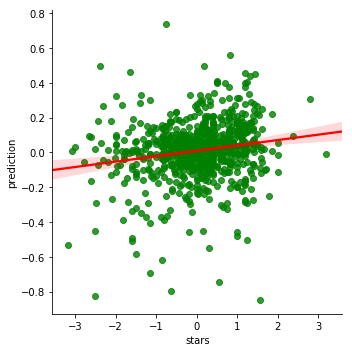

In [21]:
sns.lmplot(x='stars', y='prediction',palette='muted', data=pred_df,scatter_kws={"color": "green"},line_kws={'color': 'red'})

In [29]:
user_id = np.random.choice(rec.all_users)
print(user_id)

DVu9x-0LrA3VfJjVE4ovVw


In [43]:
json.loads(rec.recommend(user_id, 3))

The Predicted Points of Interest for Selected User are:
User Most Likey to check in following restaurants:
Format:
Restaurant Address:
Restaurant Category:
Restaurant Name:
Restaurant Rating:


[{u'address': u'50-54 Henderson Street',
  u'categories': [u'British', u'Restaurants'],
  u'name': u'Plumed Horse Restaurant',
  u'stars': 4.0},
 {u'address': u'112a Gorgie Road, Midlothian',
  u'categories': [u'Restaurants',
   u'Japanese',
   u'Food Delivery Services',
   u'Food'],
  u'name': u'Dim Sum Sushi',
  u'stars': 4.5},
 {u'address': u'53 Coburg Street',
  u'categories': [u'Breakfast & Brunch', u'Restaurants', u'Cafes'],
  u'name': u'Ostara',
  u'stars': 4.5}]

In [35]:
json.loads(rec.list_ratings(user_id, 3))

Users previous ratings for restaurants and their details are:


[{u'address': u'3 Grove Street',
  u'categories': [u'Vietnamese', u'Restaurants'],
  u'name': u'Pho Vietnam House',
  u'stars': 4.5},
 {u'address': u'75 St Leonards St',
  u'categories': [u'Restaurants', u'British', u'Modern European'],
  u'name': u'Blonde Restaurants',
  u'stars': 4.0},
 {u'address': u'50 Potterow',
  u'categories': [u'Food',
   u'Imported Food',
   u'Restaurants',
   u'Pakistani',
   u'Specialty Food',
   u'Ethnic Food'],
  u'name': u'The Original Mosque Kitchen',
  u'stars': 4.0}]

####citation:https://github.com/dvgodoy/YelpDatasetChallenge